# RespiCoV sequencing analysis

Reads fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers

## Initialization and configuration

In [3]:
from Bio.Seq import Seq
from Bio import SeqIO
import os
import gzip
import pandas as pd

fastQBaseDir = "../20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/"

pd.options.display.max_rows = 100
pd.options.display.min_rows = 50

primers = list(SeqIO.parse("RespiCovPrimers.fasta", "fasta"))
print("Read %i primers" % (len(primers)))

Read 113 primers


## Utility functions

In [79]:
from Bio import Align
from IPython.display import clear_output 
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from dataclasses import dataclass
import time

show_progress = True
debug_match = False

# Look for at least an 80% match against primers
# Below about 70% we seem to get huge numbers of matches just by chance
match_threshold = 0.80

#def getReads(subdir):
    
@dataclass
class Hit():
    primer: Seq
    start: int
    end: int
    rev: bool
    mr: float
    
# Generate all exact matches from the primers set (including reverse complements)
# from a given fastQ file
def getPrimerMatches(subdir):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.gap_score = -1
    aligner.mismatch_score = 0
    toPrint = 10 if debug_match else 0
    
    fastQDir = os.path.join(fastQBaseDir, subdir)
    for fastQFile in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        if show_progress:
            print("Processing ", fastQFile, end="")
        reads = 0
        start = time.process_time()
        with gzip.open(os.path.join(fastQDir, fastQFile), "rt") as handle:
            for record in SeqIO.parse(handle, "fastq"):
                hits = []
                for primer in primers:
                    for query in (primer.seq, primer.seq.reverse_complement()):
                        # Find the single best alignment
                        # Scoring seems to be >10x faster than finding alignments
                        score = pairwise2.align.localms(record.seq, query, 1, 0, -1, -1, \
                                                        one_alignment_only=True, score_only=True)
                        mr = score / len(query)
                        if mr >= match_threshold:
                            [alignment] = pairwise2.align.localms(record.seq, query, 1, 0, -1, -1, \
                                                                  one_alignment_only=True)
                            # TODO consider looking for the same primer elsewhere by masking the match?
                            if toPrint > 0:
                                print("Mt: ", mt)
                                print(format_alignment(*alignment))
                                toPrint -= 1
                            hits.append(Hit(
                                primer=primer, 
                                start=alignment.start, 
                                end=alignment.end,
                                rev=query != primer.seq,
                                mr=mr))
                yield (record, hits)
                if show_progress:
                    reads += 1
                    if reads % 20 == 0:
                        print(".",end="")
        if show_progress:
            elapsed = time.process_time() - start
            print("  %.2fs" % elapsed)
#            clear_output(wait=True)
                
def getAllPrimerMatches():
    for dir in sorted(os.listdir(fastQBaseDir)):
        if dir.startswith("barcode"):
            for (r,h) in getPrimerMatches(dir):
                yield (dir, r, h)

## How many primers are found in each read?

In [78]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (record, hits) in getPrimerMatches("barcode07"):
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal * 100, ndigits=2))
table

AttributeError: 'str' object has no attribute 'DataFrame'

## What is the distribution of primer match scores

Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........................................  16.01s


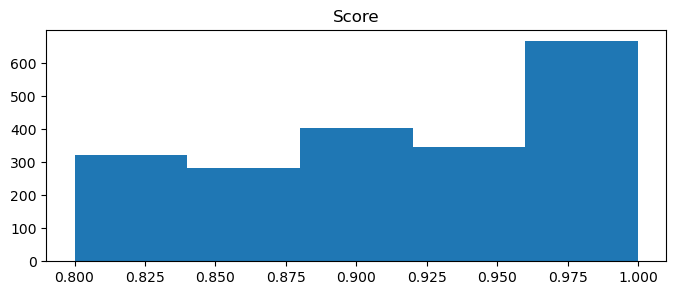

In [47]:
from collections import Counter

mrs = []
for (record, hits) in getPrimerMatches("barcode07"):
    for hit in hits:
        mrs.append(hit.mr)

pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=5, grid=False);

## How often is each primer seen?

In [63]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (record, hits) in getPrimerMatches("barcode07"):
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........................................  15.99s


,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Rhinovirus/Enterovirus 2,29,22,2.52,0.89
Rhinovirus/Enterovirus 1,29,21,2.48,0.87
SARS coronavirus 1/2 3,24,22,2.28,0.96
Human adenovirus 8,22,22,2.18,0.88
Influenza A virus 2,19,25,2.18,0.97
Influenza A virus 1,19,22,2.03,0.92
Human adenovirus 1,22,19,2.03,0.90
Human adenovirus 9,19,22,2.03,0.89
MERS coronavirus 1,20,21,2.03,0.95


## Which primers are never seen exactly?

In [62]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), 0.0)

for (dir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        if primerMaxMatch[hit.primer.description] < hit.mr:
            primerMaxMatch[hit.primer.description] = hit.mr

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

Processing  FAV39017_pass_barcode01_1d0a44b7_0.fastq.gz................................  13.06s
Processing  FAV39017_pass_barcode02_1d0a44b7_0.fastq.gz..................................  13.26s
Processing  FAV39017_pass_barcode03_1d0a44b7_0.fastq.gz.....................  9.26s
Processing  FAV39017_pass_barcode04_1d0a44b7_0.fastq.gz...............................  12.00s
Processing  FAV39017_pass_barcode05_1d0a44b7_0.fastq.gz..................................  13.23s
Processing  FAV39017_pass_barcode06_1d0a44b7_0.fastq.gz......................................  15.19s
Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........................................  15.95s
Processing  FAV39017_pass_barcode08_1d0a44b7_0.fastq.gz............................................  15.55s


,Max Match
Primer,
Influenza A virus 22,0.956522
Influenza A virus 20,0.956522
Influenza B virus 5,0.866667
Human respiratory syncytial virus 1,0.000000


## What's the distribution of read lengths and primer positions?

Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........................................  16.00s


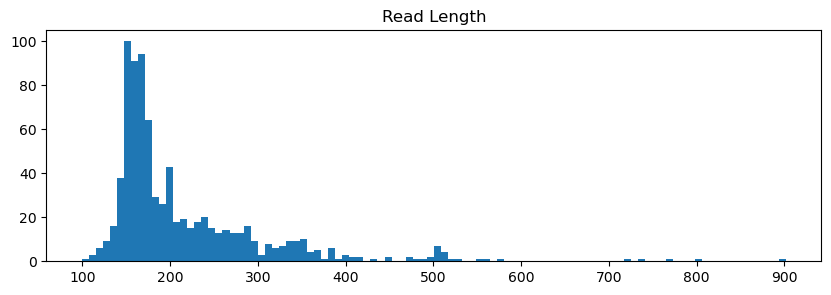

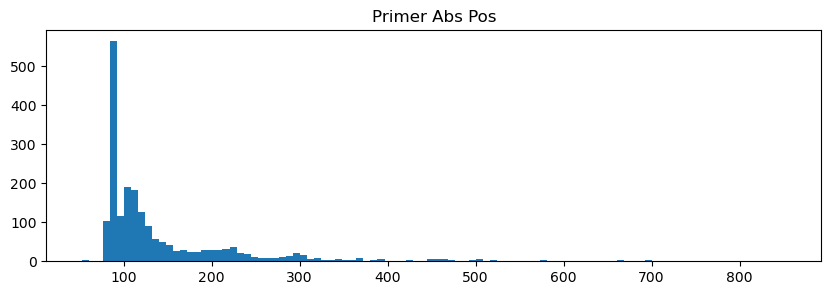

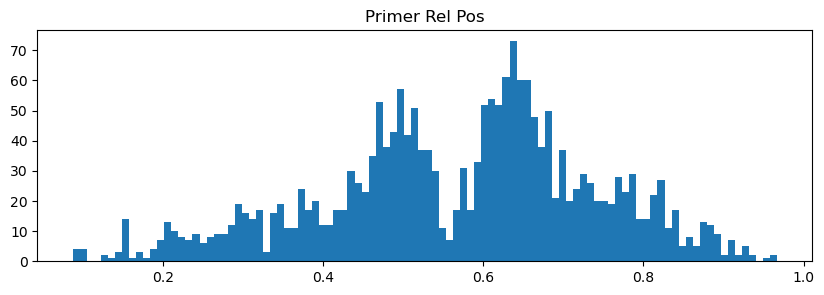

In [49]:
lengths=[]
paPos=[]
prPos=[]

for (record, hits) in getPrimerMatches("barcode07"):
    lengths.append(len(record.seq))
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(record.seq), hits)

pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,3), grid=False);

## Find possible primer pairs

In [70]:
showSequence = True
for (dir, record, hits) in getAllPrimerMatches():
    for hit1 in hits:
        if not hit1.rev:
            pd = hit1.primer.description[:hit1.primer.description.rindex(' ')]
            for hit2 in hits:
                if hit2.rev and hit2.primer.description.startswith(pd):
                    span = hit2.start - hit1.end - 1 if hit2.start > hit1.start else hit1.start - hit2.end - 1
                    if span > 150:
                        print("%s %s: %d %s @(%d,%d) %.2f - %s @(%d,%d) %.2f" % \
                              (dir, record.id, span, hit1.primer.description, hit1.start, hit1.end, hit1.mr, \
                               hit2.primer.description, hit2.start, hit2.end, hit2.mr))
                        if showSequence:
                            (s,e) = (hit1.start, hit2.end) if hit2.start > hit1.start else (hit2.start, hit1.end)
                            print(record.seq[s:e])
                            print()

barcode01 969da253-f753-4b8b-b3e9-7c8ebc79e8f5: 2 Human adenovirus 1 @(282,302) 0.80 - Human adenovirus 9 @(262,279) 0.83
CGGGCTCCAGGTACTCCATTCCTCAATTACCTGAGTCCCT

barcode01 61b2df41-2b66-44a9-a2f1-941c4cd12d94: -1 Influenza A virus 16 @(136,157) 1.00 - Influenza A virus 1 @(117,136) 0.95
CAGCTGGCAAGTGCACCAGTGACAACTTGAGCTGGACCAT

barcode01 61b2df41-2b66-44a9-a2f1-941c4cd12d94: -1 Influenza A virus 16 @(136,157) 1.00 - Influenza A virus 2 @(117,136) 1.00
CAGCTGGCAAGTGCACCAGTGACAACTTGAGCTGGACCAT

barcode01 61b2df41-2b66-44a9-a2f1-941c4cd12d94: -1 Influenza A virus 17 @(136,157) 0.95 - Influenza A virus 1 @(117,136) 0.95
CAGCTGGCAAGTGCACCAGTGACAACTTGAGCTGGACCAT

barcode01 61b2df41-2b66-44a9-a2f1-941c4cd12d94: -1 Influenza A virus 17 @(136,157) 0.95 - Influenza A virus 2 @(117,136) 1.00
CAGCTGGCAAGTGCACCAGTGACAACTTGAGCTGGACCAT

barcode01 03418cb5-b89a-45bf-87d9-ae2cdae7783a: -1 Influenza A virus 1 @(134,153) 0.95 - Influenza A virus 1 @(115,134) 0.95
CAGCTGGCAAGTGCACCAGCTGGTGCACTTGCCAGCTG


# Debugging

In [71]:
# Dump all the matches for debugging purposes (verbose)
matches = 0
records = 0
for (record, hits) in getPrimerMatches("barcode07"):
    records += 1
    if len(hits)>0:
        matches += 1
        print("Read %s len %i matches:" % (record.id,len(record.seq)))
        for hit in hits:
            print("   %.2f %i-%i: %s%s" % (hit.mr, hit.start, hit.end, hit.primer.description, " (rev)" if hit.rev else ""))
print("Found %i matches in %i reads" % (matches, records))

Read f4603494-90b7-4ea0-baaf-ac702ca3f693 len 140 matches:
   1.00 66-88: Herpes simplex virus 1
Read 25b3638b-0fef-4a35-b889-b55f0d804efa len 123 matches:
   0.90 73-94: Rhinovirus/Enterovirus 3
Read 9abe5abf-79bd-4de0-a9ba-25dcbb5dc7cf len 147 matches:
   0.83 65-80: Human adenovirus 7
   0.83 65-83: Human adenovirus 9
   1.00 82-103: Legionelle pneumophila 1 (rev)
Read bbda416d-55bf-4e9d-b27e-d80d28a49089 len 173 matches:
   0.95 62-82: Human bocavirus 1
Read ce9293f9-8cde-4ca0-8477-198a988631fc len 269 matches:
   1.00 67-89: Human coronavirus NL63 2
Read 24b1cfc3-949e-403d-93c7-53a486e2de65 len 157 matches:
   0.80 73-93: Human adenovirus 1
   0.86 90-112: SARS coronavirus 1/2 4 (rev)
Read c99c9906-3dff-45c4-a149-4ceadd700d61 len 194 matches:
   0.89 113-140: Human coronavirus HKU1 2 (rev)
Read 40518152-598c-42b8-8358-9d85dc97a931 len 161 matches:
   0.95 83-103: SARS coronavirus 1/2 1 (rev)
   0.85 59-80: Varizella zoster virus 2
Read 5ba5b124-215a-4a01-8e8c-dccf70342631 len 155 